# Twitter Sentiment Analysis

## Random Forest Model

### Import libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

### Load datasets

In [2]:
train_df = pd.read_csv('datasets/train_preprocessed.csv').dropna(subset=['clean_text'])
test_df = pd.read_csv('datasets/test_preprocessed.csv').dropna(subset=['clean_text'])
val_df = pd.read_csv('datasets/validation_preprocessed.csv').dropna(subset=['clean_text'])

In [3]:
print(f"Training data: {train_df.shape}")
print(f"Test data: {test_df.shape}")
print(f"Validation data: {val_df.shape}")

Training data: (55638, 6)
Test data: (13895, 6)
Validation data: (1000, 6)


### Define features 'X' and target 'Y'

In [4]:
X_train = train_df['clean_text']
y_train = train_df['label_encoded']

X_val = val_df['clean_text']
y_val = val_df['label_encoded']

In [6]:
# Build pipeline
rf_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=10000, 
                              ngram_range=(1,3), 
                              token_pattern=r'(?u)\b\w\w+\b|[:;=8][\-o\*\']?[\)\]\(\[dDpP/\:\}\{@\|\\]'
                              )),
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1))
])

In [7]:
# Train model
print("Training the model...")
rf_pipeline.fit(X_train, y_train)
print("Training complete.")

Training the model...
Training complete.


In [8]:
# Evaluate
y_val_pred = rf_pipeline.predict(X_val)

In [9]:
# Metrics
accuracy = accuracy_score(y_val, y_val_pred)
print(f"Validation accuracy: {accuracy:.4f}")
print("\nClassification_report:\n")
print(classification_report(y_val, y_val_pred))

Validation accuracy: 0.9560

Classification_report:

              precision    recall  f1-score   support

           0       0.96      0.96      0.96       266
           1       0.95      0.96      0.96       457
           2       0.96      0.95      0.95       277

    accuracy                           0.96      1000
   macro avg       0.96      0.96      0.96      1000
weighted avg       0.96      0.96      0.96      1000



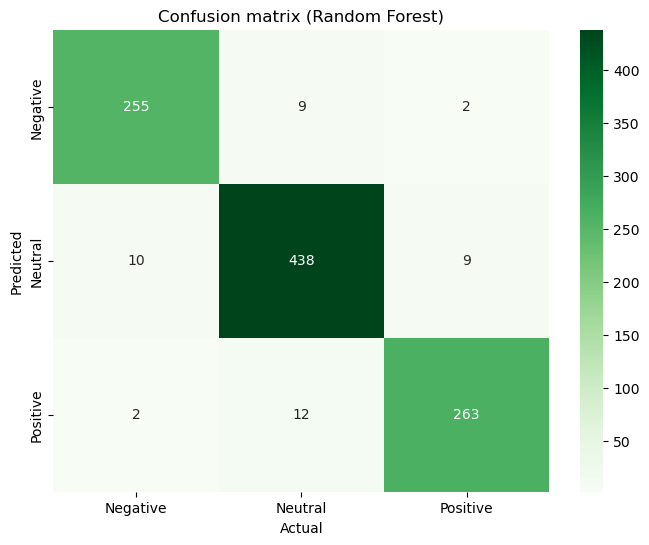

In [10]:
# Confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_val, y_val_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Negative', 'Neutral', 'Positive'],
            yticklabels=['Negative', 'Neutral', 'Positive'])
plt.title('Confusion matrix (Random Forest)')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()

In [11]:
# Sanity check

train_accuracy = rf_pipeline.score(X_train, y_train)
val_accuracy = rf_pipeline.score(X_val, y_val)

print(f"Training accuracy: {train_accuracy:.2%}")
print(f"Validation accuracy: {val_accuracy:.2%}")

Training accuracy: 98.29%
Validation accuracy: 95.60%


In [12]:
gap = train_accuracy - val_accuracy

if gap>0.10:
    print(f"High overfitting (Gap: {gap:.1%}). Model is memorizing data.")
elif gap <0.01:
    print(f"Excellent. Little to no overfitting. (Gap: {gap:.1%})")
else:
    print(f"Normal. Slight overfitting is expected. (Gap: {gap:.1%})")

Normal. Slight overfitting is expected. (Gap: 2.7%)


In [13]:
print("\n" + "="*40)
print("ERROR ANALYSIS: Viewing Misclassified Tweets")
print("="*40)

# Get predictions again
y_val_pred = rf_pipeline.predict(X_val)

# Create a DataFrame to view mistakes easier
# We use X_val to see the text, and y_val for the actual label
errors_df = pd.DataFrame({
    'Tweet': X_val,
    'Actual_Label': y_val,
    'Predicted_Label': y_val_pred
})

# Filter for rows where Prediction does not match Actual
mistakes = errors_df[errors_df['Actual_Label'] != errors_df['Predicted_Label']]

print(f"Total Mistakes: {len(mistakes)} out of {len(X_val)}")
print("\n--- Sample of 5 Misclassified Tweets ---")

# Print 5 random mistakes
# We use .sample() to pick random ones, or .head() for the first 5
if len(mistakes) > 0:
    for i, row in mistakes.sample(min(5, len(mistakes)), random_state=42).iterrows():
        print(f"\nTweet: \"{row['Tweet']}\"")
        print(f"True: {row['Actual_Label']} | Pred: {row['Predicted_Label']}")
        print("-" * 30)
else:
    print("Incredible! No mistakes found (Accuracy is 100%).")


ERROR ANALYSIS: Viewing Misclassified Tweets
Total Mistakes: 44 out of 1000

--- Sample of 5 Misclassified Tweets ---

Tweet: "make crappy @immortal til treasure 3 day 1 dota2"
True: 1 | Pred: 0
------------------------------

Tweet: "hilarious fuck 🤣"
True: 2 | Pred: 0
------------------------------

Tweet: "smh"
True: 0 | Pred: 1
------------------------------

Tweet: "xsxfridgesweep 😂 amazing"
True: 1 | Pred: 2
------------------------------

Tweet: "holy shit"
True: 0 | Pred: 2
------------------------------


/opt/anaconda3/lib/python3.13/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


### Hyperparameter Tuning

In [14]:
from sklearn.model_selection import RandomizedSearchCV

param_dist = {
    'rf__n_estimators': [300, 500, 700],
    'rf__max_depth': [None, 30, 50],
    'rf__min_samples_split': [5, 10],
    'rf__min_samples_leaf': [1, 2],
    'rf__max_features': ['sqrt'],
    'rf__class_weight': ['balanced', 'balanced_subsample']
}

In [15]:
rf_random = RandomizedSearchCV(
    estimator = rf_pipeline,
    param_distributions = param_dist,
    n_iter = 15,
    cv = 3,
    verbose = 2,
    random_state = 42,
    n_jobs=-1,
    scoring='accuracy'
)

print("Tuning Random Forest...")
rf_random.fit(X_train, y_train)

Tuning Random Forest...
Fitting 3 folds for each of 15 candidates, totalling 45 fits
[CV] END rf__class_weight=balanced, rf__max_depth=30, rf__max_features=sqrt, rf__min_samples_leaf=2, rf__min_samples_split=5, rf__n_estimators=300; total time=  10.2s
[CV] END rf__class_weight=balanced, rf__max_depth=None, rf__max_features=sqrt, rf__min_samples_leaf=1, rf__min_samples_split=5, rf__n_estimators=300; total time=  58.4s
[CV] END rf__class_weight=balanced, rf__max_depth=30, rf__max_features=sqrt, rf__min_samples_leaf=2, rf__min_samples_split=5, rf__n_estimators=300; total time=   9.5s
[CV] END rf__class_weight=balanced, rf__max_depth=30, rf__max_features=sqrt, rf__min_samples_leaf=2, rf__min_samples_split=5, rf__n_estimators=300; total time=  12.5s
[CV] END rf__class_weight=balanced, rf__max_depth=None, rf__max_features=sqrt, rf__min_samples_leaf=1, rf__min_samples_split=5, rf__n_estimators=300; total time= 1.1min
[CV] END rf__class_weight=balanced_subsample, rf__max_depth=50, rf__max_feat

,"estimator estimator: estimator objectAn object of that type is instantiated for each grid point.This is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",Pipeline(step...m_state=42))])
,"param_distributions param_distributions: dict or list of dictsDictionary with parameters names (`str`) as keys and distributionsor lists of parameters to try. Distributions must provide a ``rvs``method for sampling (such as those from scipy.stats.distributions).If a list is given, it is sampled uniformly.If a list of dicts is given, first a dict is sampled uniformly, andthen a parameter is sampled using that dict as above.","{'rf__class_weight': ['balanced', 'balanced_subsample'], 'rf__max_depth': [None, 30, ...], 'rf__max_features': ['sqrt'], 'rf__min_samples_leaf': [1, 2], ...}"
,"n_iter n_iter: int, default=10Number of parameter settings that are sampled. n_iter tradesoff runtime vs quality of the solution.",15
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.If None, the estimator's score method is used.",'accuracy'
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",-1
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given the ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``RandomizedSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strate

[CV] END rf__class_weight=balanced, rf__max_depth=None, rf__max_features=sqrt, rf__min_samples_leaf=1, rf__min_samples_split=10, rf__n_estimators=500; total time= 1.3min
[CV] END rf__class_weight=balanced, rf__max_depth=None, rf__max_features=sqrt, rf__min_samples_leaf=2, rf__min_samples_split=10, rf__n_estimators=500; total time=  36.8s
[CV] END rf__class_weight=balanced_subsample, rf__max_depth=None, rf__max_features=sqrt, rf__min_samples_leaf=2, rf__min_samples_split=10, rf__n_estimators=700; total time=  51.1s
[CV] END rf__class_weight=balanced, rf__max_depth=30, rf__max_features=sqrt, rf__min_samples_leaf=1, rf__min_samples_split=5, rf__n_estimators=300; total time=  11.0s
[CV] END rf__class_weight=balanced, rf__max_depth=50, rf__max_features=sqrt, rf__min_samples_leaf=2, rf__min_samples_split=5, rf__n_estimators=500; total time=  24.1s
[CV] END rf__class_weight=balanced_subsample, rf__max_depth=None, rf__max_features=sqrt, rf__min_samples_leaf=2, rf__min_samples_split=10, rf__n_e

In [16]:
print(f"Best parameters: {rf_random.best_params_}")
print(f"Best CV score: {rf_random.best_score_:.4f}")

Best parameters: {'rf__n_estimators': 300, 'rf__min_samples_split': 5, 'rf__min_samples_leaf': 1, 'rf__max_features': 'sqrt', 'rf__max_depth': None, 'rf__class_weight': 'balanced'}
Best CV score: 0.8656


In [17]:
best_rf = rf_random.best_estimator_
y_val_tuned = best_rf.predict(X_val)

In [18]:
# Metrics for tuned model
tuned_accuracy = accuracy_score(y_val, y_val_tuned)
print(f"Tuned Validation accuracy: {tuned_accuracy:.4f}")
print("\nClassification_report:\n")
print(classification_report(y_val, y_val_tuned))

Tuned Validation accuracy: 0.9640

Classification_report:

              precision    recall  f1-score   support

           0       0.97      0.97      0.97       266
           1       0.96      0.96      0.96       457
           2       0.96      0.96      0.96       277

    accuracy                           0.96      1000
   macro avg       0.96      0.96      0.96      1000
weighted avg       0.96      0.96      0.96      1000



### Evaluating on Test Set

In [19]:
X_test = test_df['clean_text']
y_test = test_df['label_encoded']

In [21]:
y_test_pred = best_rf.predict(X_test)

In [23]:
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test Validation Accuracy: {test_accuracy:.4f}")
print("\nClassification Report:\n")
print(classification_report(y_test, y_test_pred))

Test Validation Accuracy: 0.8974

Classification Report:

              precision    recall  f1-score   support

           0       0.91      0.90      0.91      4239
           1       0.90      0.90      0.90      5837
           2       0.88      0.88      0.88      3819

    accuracy                           0.90     13895
   macro avg       0.90      0.90      0.90     13895
weighted avg       0.90      0.90      0.90     13895



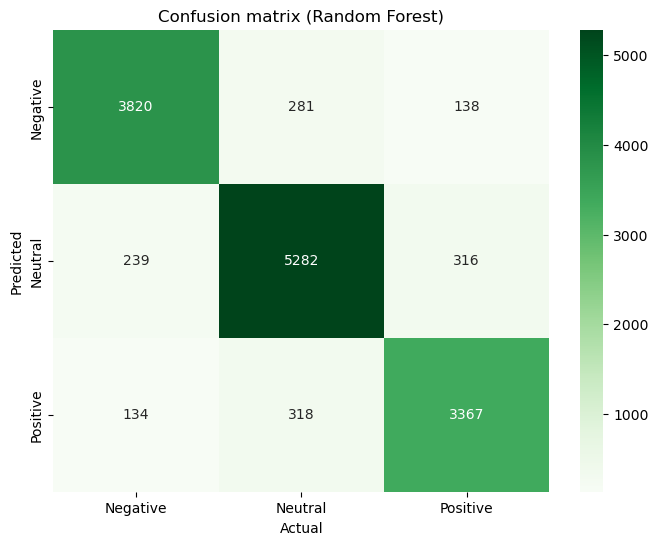

In [24]:
# Confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Negative', 'Neutral', 'Positive'],
            yticklabels=['Negative', 'Neutral', 'Positive'])
plt.title('Confusion matrix (Random Forest)')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()